In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [2]:
ab_test = pd.read_csv('ab_data.csv')   
ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
ab_test.shape

(294478, 5)

In [4]:
ab_test.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [5]:
ab_test.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
pd.crosstab(ab_test['group'], ab_test['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [7]:
ab_test = ab_test.drop(ab_test[(ab_test.landing_page == "new_page") & (ab_test.group == "control")].index)
ab_test = ab_test.drop(ab_test[(ab_test.landing_page == "old_page") & (ab_test.group == "treatment")].index)

In [8]:
pd.crosstab(ab_test['group'], ab_test['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


In [9]:
ab_test.shape

(290585, 5)

In [10]:
ab_test.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [11]:
ab_test=ab_test.drop_duplicates(subset=['user_id'])

In [12]:
ab_test.shape

(290584, 5)

In [13]:
effect_size = sms.proportion_effectsize(0.12, 0.14)    # Calculating effect size based on our expected rates
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8,  alpha=0.05,ratio=1)  # Calculating sample size needed
required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4433


In [15]:
import random
seed=50
control_group = ab_test.query('group == "control"').sample(required_n, random_state=seed)
treatment_group = ab_test.query('group == "treatment"').sample(required_n, random_state=seed)

In [16]:
ab_test_sample = pd.concat([control_group, treatment_group], axis=0)

In [17]:
ab_test_sample

,user_id,timestamp,group,landing_page,converted
248710,801834,2017-01-14 20:56:07.303711,control,old_page,0
64837,705599,2017-01-16 18:55:55.992050,control,old_page,0
259801,644738,2017-01-09 04:34:55.269130,control,old_page,0
260913,920216,2017-01-10 11:08:41.028431,control,old_page,0
158932,887759,2017-01-06 00:07:56.020662,control,old_page,0
...,...,...,...,...,...
195023,705728,2017-01-10 17:25:34.958721,treatment,new_page,0
193892,771177,2017-01-16 23:21:28.329277,treatment,new_page,0
205674,761236,2017-01-03 18:22:57.792468,treatment,new_page,0
275633,737813,2017-01-03 19:58:42.165926,treatment,new_page,0


In [18]:
ab_test_sample.group.value_counts()

group
control      4433
treatment    4433
Name: count, dtype: int64

In [19]:
import numpy as np
conversion_rates = ab_test_sample.groupby('group')['converted'].agg(np.mean)
conversion_rates

C:\Users\user\AppData\Local\Temp\ipykernel_13528\2631220395.py:2: FutureWarning: The provided callable <function mean at 0x000001756E31E200> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = ab_test_sample.groupby('group')['converted'].agg(np.mean)


group
control      0.124069
treatment    0.114144
Name: converted, dtype: float64

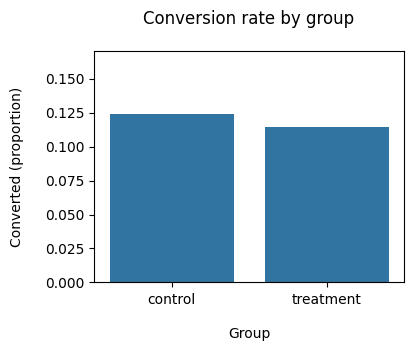

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(4,3))

sns.barplot(x=ab_test_sample['group'], y=ab_test_sample['converted'], errorbar=('ci', False))

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [21]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test_sample[ab_test_sample['group'] == 'control']['converted']
treatment_results = ab_test_sample[ab_test_sample['group'] == 'treatment']['converted']

In [23]:
treatment_results

149650    0
90023     0
82729     0
225535    0
177983    0
         ..
195023    0
193892    0
205674    0
275633    0
46457     0
Name: converted, Length: 4433, dtype: int64

In [24]:
n_con = control_results.count()
n_treat = treatment_results.count()
print(n_con)
print(n_treat)

4433
4433


In [25]:
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

print(f'successes: {successes}')
print(f'nobs: {nobs}')

successes: [550, 506]
nobs: [4433, 4433]


In [26]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.44
p-value: 0.149
ci 95% for control group: [0.114, 0.134]
ci 95% for treatment group: [0.105, 0.124]
